# Demo: Comparison of MCMC Algorithms for a Bimodal Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In the previous two examples we discussed the (perhaps too) simple problem of using MH and HMC to draw samples from a univariate normal distribution. We saw that the purely random nature of sample motion in MH led to slow convergence of our histogram to a Gaussian shape for small stepsizes. On the other hand, the Hamiltonian flow we use to move between iterates in HMC allows us to move a lot further and get a much more qualitatively accurate histogram a lot faster. In this demo, we put these two routines to the test even more dramatically by looking at a distribution with *two peaks*. Recall from statistics that such a distribution is called **bimodal**. Specifically, we want the two peaks to be separated by a sizable distance. Thus, if our claim about random walks being too slow to capture all qualitative features of the distribution in a reasonable amount of time is true, MH should perform terribly in this situation and possibly fail to capture one of the Gaussian humps. On the other hand, HMC should be able to at least tell us another hump is there, though perhaps getting the relative hump sizes correct is too much to ask for. 

Consider the following "mixed Gaussian" bimodal distribution,
$$
f(x) = \frac{a_{1}}{\sigma_1\sqrt{2\pi}}\exp\left(-\frac12\left(\frac{x-\mu_1}{\sigma_1}\right)^2\right)+ \frac{a_{2}}{\sigma_2\sqrt{2\pi}}\exp\left(-\frac12\left(\frac{x-\mu_2}{\sigma_2}\right)^2\right). 
$$
where $a_{1}+a_{2}=1$. To make the distribution a bit skewed, we pick $a_{1}>>a_{2}$. We also pick $\mu_{2}\gg \mu_{1}$ so both peaks are separated far apart. 

We define a Python function evaluating $f(x)$ below. 

In [2]:
# prescribe all the parameters of the distribution

a1 = 0.7
    
a2 = 0.3
    
mu1 = -1.
    
sigma1 = 1. 
    
mu2 = mu1 + 8.*sigma1 #4.*sigma1
    
sigma2 = 1.

def f(x): 
    
    normalization = 1./(np.sqrt(2.*np.pi))
    
    out = (a1/sigma1)*np.exp((-0.5/sigma1**2)*((x-mu1)/(sigma1))**2) + (a2/sigma2)*np.exp((-0.5/sigma2**2)*((x-mu2)/(sigma2))**2)

    out *= normalization
    
    return out

Now we plot out chosen distribution. 

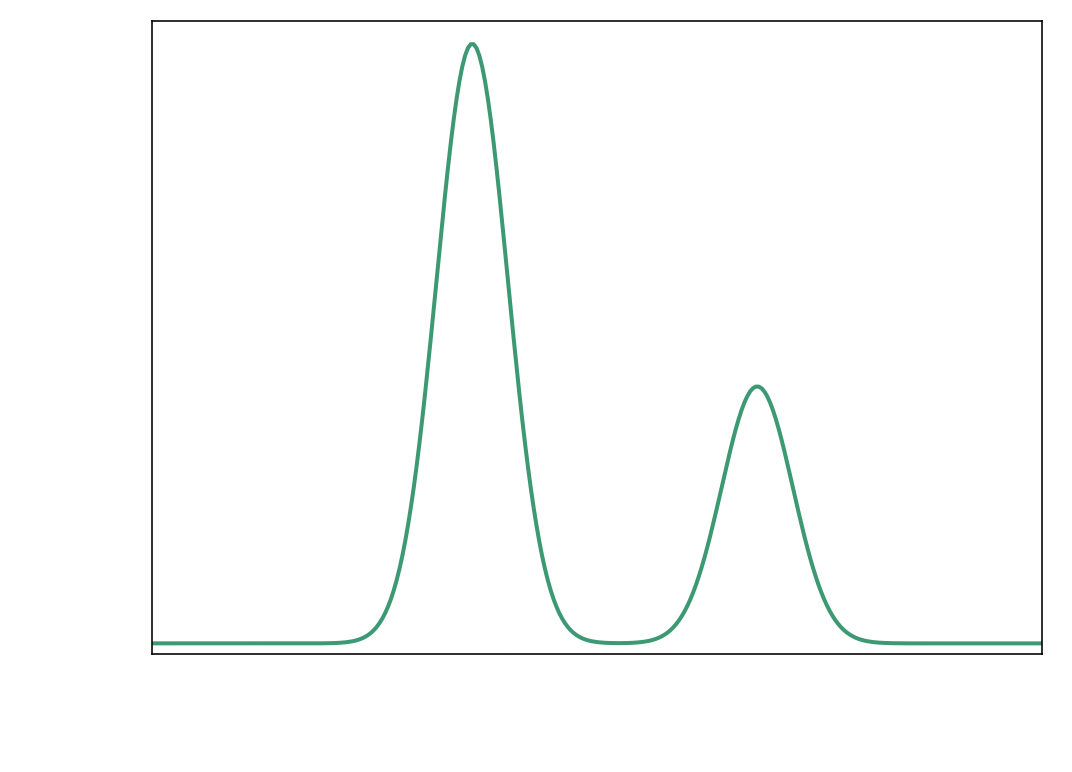

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

xx = xx = np.linspace(-20,20, num = 501)
plt.plot(xx, f(xx), linestyle='solid', color='xkcd:ocean green', linewidth='2')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([-10,15])
plt.ylim([-5e-3, 0.29])

plt.xlabel(r"$x$", fontsize=30, color = 'w')
plt.ylabel(r"$f(x)$", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

By default, the peaks of the two Gaussian humps are well-separated: there is a "no man's land" between humps where $f(x)\approx 0$. 

Next, we implement pure MH sampling. 

In [4]:
def mh_sampling(x0 = 0.0, h=5e-1, N=1e4):
# x0 = initial guess

# h = maximum step size

# N = number of samples 

    x = np.zeros(N, dtype=float) # vector storing samples 
    
    # use initial guess
    x[0]= x0
    
    # initialize rejection counter
    rejected = 0. 
    
    # set timer
    start = time.time()

    for t in np.arange(1,N):
        
        # randomly select step size
        increment = np.random.uniform(low=-h,high=h) 
        
        # note: the above seems to work a lot better than using a "true" (2-state Bernoulli)
        # random walk with fixed step size! 
    
        # tentative next guess
        y = x[t-1] + increment
    
        alpha = f(y)/f(x[t-1])
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[t] = y
                    
        elif u > alpha:
    
            x[t] = x[t-1]
        
            rejected += 1
    
    rej_ratio =  rejected/N 
            
    print('Rejection Ratio for' , N, 'samples = %.4f' % rej_ratio) 
    
    end = time.time()
    
    runtime  = end - start
    
    print('Runtime for' , N, 'samples = %.2f' % runtime, 'seconds')
            
    return x 

We start our random walk at the origin and get $N$ samples. 

In [5]:
x0 = 0.0 #np.random.uniform(low=-sigma, high=sigma)

x = mh_sampling(x0, h = 1., N=int(1e3))

Rejection Ratio for 1000 samples = 0.1950
Runtime for 1000 samples = 0.03 seconds


We now get a histogram for our data. 

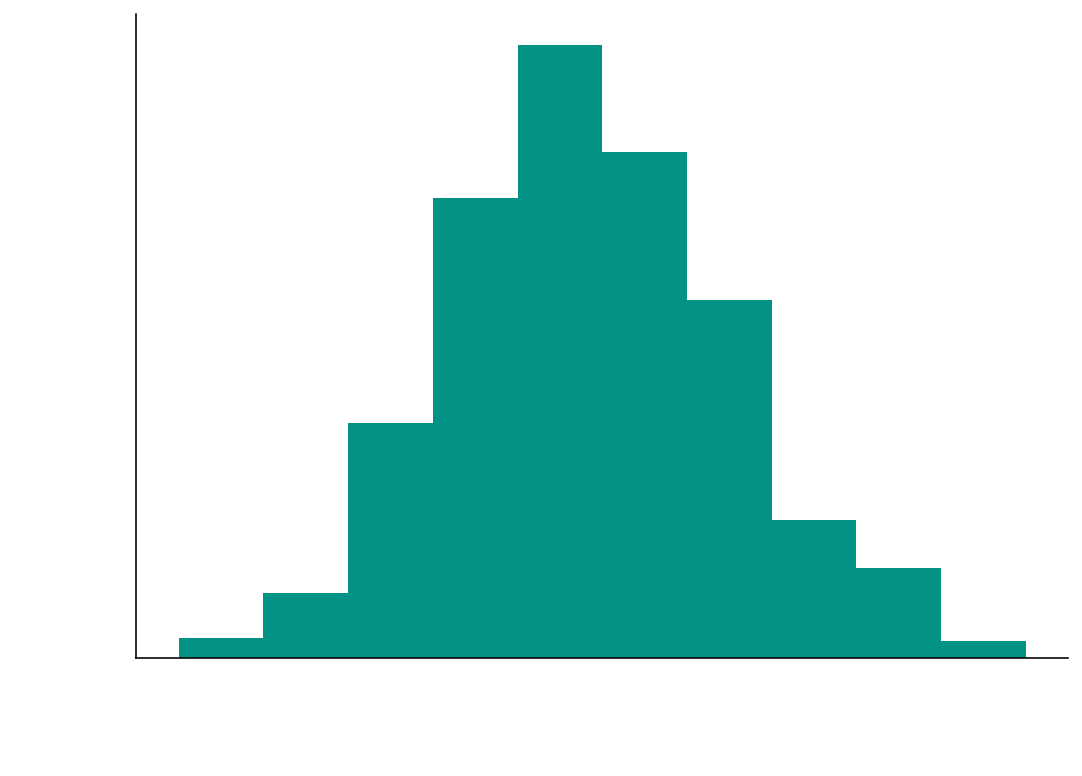

In [6]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(x, color='xkcd:teal')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlabel(r"Position $x$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

#plt.xlim([-4,4]) # note: this sometimes produces useless white space on one side of the 
# histogram, which is usually a big no-no for nice figure presentation! But in the next
# demo we find there's a method in such madness. 

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

For the default parameters of this notebook (including $N=10^3$, I have almost never found that MH can capture both peaks. Indeed, it usually gravitates towards the larger peak and gets stuck there. So, as predicted earlier, the slowness of pure random walk has caused us to miss a crucial qualitative feature of the distribution in our sampling. 

I'm pulling the wool over your eyes a bit here, as one can get MH to discover the second peak if you pick a maximum random walk stepsize of $h\approx 10$. However, typically one wants to choose a smaller $h$ to ensure that the sample sequence is highly autocorrelated. So, if you're just naively using "typical" parameter values, you will get a poor sample. You may argue that using "typical" parameter values is a terrible idea because sampling should accommodate all our *a priori* knowledge we have about our target distribution: if we know there's a no-man's land between peaks, our MH random walk should be capable of jumping across that gap. However, think about how we know the no-man's land exists: we simply plotted $f(x)$ and saw it. However, for more complex problems involving high-dimensional data, visualizing the distribution is impossible and identifying bimodality is therefore difficult. You may be able to find the local extrema of your distribution numerically and choose stepsizes according to these computations, but this is a computationally nontrivial problem in and of itself, and best-case scenario it would require a pretty intense preprocessing stage. So, when faced with a tougher problem, you may have no choice but to start with "typical" parameter values. 

There is another argument against why we shouldn't really say MH does well here even though $h\approx 10$ happens to detect the peak, though this argument is on more of a folkloric level. For any algorithm that involves user-specified parameters, there are often magic parameter values that fix major performance issues. However, for certain problems identifying magic values is so time-consuming that it may become impossible in practice. So, if there is an alternative algorithm that performs better without intensive parameter tuning, that alternative is probably worth using instead.  

Now, we turn towards HMC. We start by defining a Python function for evaluating $f'(x)$, which is required for our leapfrogger. 

In [7]:
def fprime(x):
    
    normalization = 1./(np.sqrt(2.*np.pi))
    
    A1 = normalization*a1/sigma1
    
    A2 = normalization*a2/sigma2
    
    out = ((x-mu1)/sigma1)*A1*np.exp((-0.5/sigma1**2)*((x-mu1)/(sigma1))**2) + ((x-mu2)/sigma2)*A2*np.exp((-0.5/sigma2**2)*((x-mu2)/(sigma2))**2)
    
    return -1*out 

In [8]:
def leapfrog(x0, m, dt = 1e-1, L = 10.):
    
    # x0 = initial state
    
    # dt = time-step size
    
    # L = number of time-steps
    
    q0, p0 = x0[0], x0[1]
    
    qold = q0
    
    pold = p0
    
    for n in np.arange(1,L):
        
        pint = pold + 0.5*dt*(-1.*fprime(qold)/f(qold))
        
        qnew = qold + dt*(1./m)*pint
        
        pnew = pint + 0.5*dt*(-1.*fprime(qnew)/f(qnew))
        
        # finally, change variable definition
        
        qold = qnew
        
        pold = pnew
    
    return np.array([qold, pold]).T

Now, we implement our sampling routine as in the baby example. 

In [9]:
def hmc_sampling(q0 = 0.0, m = 1., dt = 1e-1, L=10., N=1e2):
# q0 = initial state guess

# m = false mass parameter

# dt = leapfrog step size

# L = number of leapfrog steps per MH iteration

# N = number of MH steps

    x = np.zeros((2,N), dtype=float) # vector storing samples 
    
    # use initial guess
    x[0,0] = q0
    
    # enumerate number of rejected guesses
    rejected = 0. 
    
    start = time.time()

    for n in np.arange(1,N):
        
        # randomly choose starting momentum #TODO: change to MH? 
        p0 = np.random.normal(loc= 0., scale = m) 
        x[1,n-1] = p0
        
        # run leapfrog to advance system along Hamiltonian flow. This replaces
        # the random-sized increment we saw for MH
        y = leapfrog(x[:,n-1], m = m, dt = dt, L = L)
        
        # now decide to accept or reject the step
        alpha = f(y[0])/f(x[0,n-1])
        
        alpha *= np.exp(-(0.5/m)*(y[1]**2-x[1,n-1]**2))
        
        #print('alpha = ', alpha)
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[:,n] = y
                    
        elif u > alpha:
    
            x[:,n] = x[:,n-1]
        
            rejected += 1.
            
    rej_ratio =  rejected/N 
            
    print('Rejection Ratio for' , N, 'samples = %.4f' % rej_ratio) 
    
    end=time.time()
    
    runtime = end-start
    
    print('Runtime for' , N, 'samples = %.2f' % runtime, 'seconds')
        
    return x 

In [10]:
q0 = 0.0 #np.random.uniform(low=-sigma, high=sigma)

x = hmc_sampling(q0 = q0, m = 1., dt = 1e-1, L= 20., N = int(1e3))[0,:]

Rejection Ratio for 1000 samples = 0.7640
Runtime for 1000 samples = 0.58 seconds


Note that in this example we must be a bit careful about the leapfrog time-stepping because in the "no-man's land" the right-hand side of our ODE becomes very large. Also, you'll notice that the rejection ratio for HMC tends to be pretty high (around $0.8$!), which at first glance seems like a big issue. With a bit more thought, however, we recognize that most steps that try to cross the no-man's land must be rejected. Thus for this particular problem a high rejection ratio for HMC is actually kind of a good sign.  

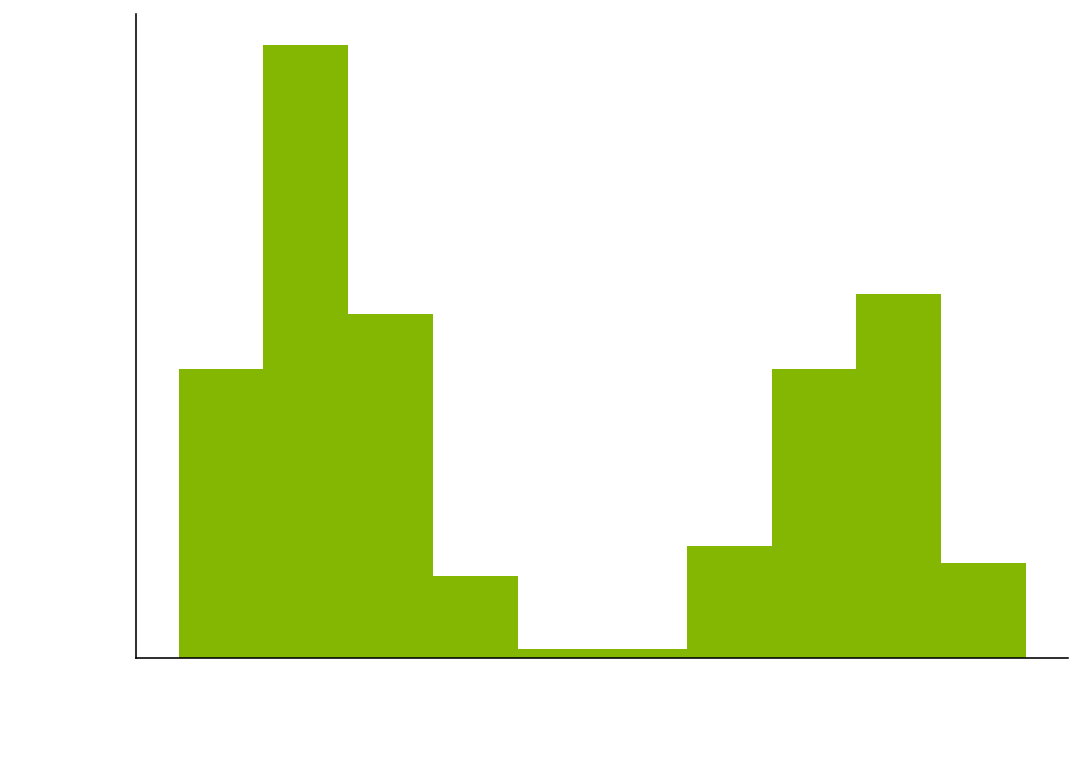

In [11]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(x, color='xkcd:dark lime')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlabel(r"Position $x$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

For $N=10^3$ and $h$ not too large, vanilla MH does a decent job of sampling the larger Gaussian hump, but does not even detect the second, smaller hump. On the other hand, HMC always finds the smaller hump (at least for the parameter values I have chosen), though it may not represent its height accurately. Even running the routines for $N=10^5$, vanilla MH tends to have a great deal of trouble finding the smaller bump and taking a decent amount of samples from it. So, for bimodal distributions with well-separated peaks, HMC gives a far better picture of the problem than MH without having to tune parameters too much. This gives even more compelling evidence that Hamiltonian flow provides a much more efficient method of exploring a distribution than does pure random walk. 